In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
import spacy
from sklearn.pipeline import make_pipeline

In [2]:
from sklearn.datasets import fetch_20newsgroups

In [3]:
ng20_df = pd.DataFrame()
groups = ['comp.graphics','rec.motorcycles','sci.med','talk.politics.misc','alt.atheism','talk.politics.guns']
a = fetch_20newsgroups(subset='train',categories=groups, remove=('headers', 'footers', 'quotes'), random_state=1)
for i,data in enumerate(a.get('data')):
    
    ng20_df.loc[i,'labels'] = a.get('filenames')[i][65:-6]
    ng20_df.loc[i,'text'] = data


In [4]:
ng20_df.labels = ng20_df.labels.str.replace("\\","")

In [5]:
ng20_df = ng20_df.loc[np.where(np.logical_not(ng20_df.text.duplicated()))[0],:]
ng20_df.text.duplicated().sum()

0

In [6]:
ng20_df.head()

,labels,text
0,talk.politics.misc,"# ## Face it, Clayton, he was not found guilty..."
1,comp.graphics,On sunsite.unc.edu in pub/multimedia/utilities...
2,alt.atheism,\nThere are definitely quite a few horrible de...
3,comp.graphics,\n\n\tThe newspaper itself is almost certainly...
4,talk.politics.misc,"Pardon me for interrupting, but why doesn't an..."


In [7]:
ng20_df.labels.value_counts()

rec.motorcycles       583
sci.med               579
comp.graphics         571
talk.politics.guns    534
alt.atheism           469
talk.politics.misc    454
Name: labels, dtype: int64

In [8]:
def clean_text(text):
    #text = re.sub("\n", ' ', text) 
   
    text = re.sub(r"[^a-zA-Z.' ]+", " ", text) #removes anything that isn't a letter
    text = re.sub(r"\W?\W?\W?\W?\W?\W",' ',text)
    text  = re.sub(r'\b\w{1}\b', '', text)
    #text = re.sub("/(^|\s+)(\S(\s+|$))+/", " ", text)
    text = re.sub(r"\W?\W?\W?\W?\W?\W",' ',text)
    text = text.lower()
    return text;

In [9]:
clean_text(ng20_df.text[600])

' all true and all good points well making career out of it is bit strong still believe that doing your own research is very very necessary would not have progressed as much as have today unless had spent the many hours in stanford med library as have done and years ago it was clear that there was no medicine that would help me so should have stopped searching thank goodness didn now found that there is indeed medicine that helps me think that what you ve said is kind of idealistic that you would go to one doctor get diagnosis maybe get second opinion and then move on with your life just as an example having seen of the top specialists in this field in the country have received different diagnoses these are the top names the ones that people come to from all over the country have had to sort all of this out myself going to support group and in fact heading that support group was helpful for while but after point found it very unproductive it was much more productive to do library resea

In [10]:
ng20_df['clean_text'] = ng20_df.text.apply(lambda x: clean_text(x))

In [11]:
ng20_df.head()

,labels,text,clean_text
0,talk.politics.misc,"# ## Face it, Clayton, he was not found guilty...",face it clayton he was not found guilty and s...
1,comp.graphics,On sunsite.unc.edu in pub/multimedia/utilities...,on sunsite unc edu in pub multimedia utilities...
2,alt.atheism,\nThere are definitely quite a few horrible de...,there are definitely quite few horrible death...
3,comp.graphics,\n\n\tThe newspaper itself is almost certainly...,the newspaper itself is almost certainly copy...
4,talk.politics.misc,"Pardon me for interrupting, but why doesn't an...",pardon me for interrupting but why doesn anyon...


In [12]:
ng20_df = ng20_df.iloc[np.where(np.logical_not(ng20_df.clean_text.duplicated()))[0],:]

In [13]:
X = ng20_df.clean_text
Y = ng20_df.labels

In [14]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split
# X_train, X_test,y_train,y_test = train_test_split(X,Y, test_size=0.25, random_state=0)


In [15]:
from sklearn.feature_extraction import text
my_stop_words = text.ENGLISH_STOP_WORDS.union(['-pron-','-PRON-','don', 'make',"think","like","just","ve","know","did"])#,"don","does","n3jxp",'people' ,'time' ,'good', 'make', "use", "way"])

In [16]:
nlp = spacy.load('en')
def lemmas(text):
    text = nlp(text)
    allwords = []
    for word in text: 
        if not word.is_stop:
            allwords.append(word.lemma_)
    return allwords;

In [17]:
# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words=my_stop_words,max_df=.5, min_df=4,
                             #tokenizer=lemmas,
                             max_features=1000)
ng20_tfidf=vectorizer.fit_transform(X)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=6

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10


C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['pron'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [18]:
ng20_tfidf.shape

(3179, 1000)

In [19]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
ng20_lsa = lsa.fit_transform(ng20_tfidf)

components_lsa = word_topic(ng20_tfidf, ng20_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                


In [20]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics,
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

ng20_lda = lda.fit_transform(ng20_tfidf) 

components_lda = word_topic(ng20_tfidf, ng20_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)


In [21]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
ng20_nmf = nmf.fit_transform(ng20_tfidf) 

components_nmf = word_topic(ng20_tfidf, ng20_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

In [22]:
print(ng20_df.labels.unique())
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    
    print(topwords.loc[topic])


['talk.politics.misc' 'comp.graphics' 'alt.atheism' 'rec.motorcycles'
 'sci.med' 'talk.politics.guns']
Topic 0:
            LSA          LDA             NNMF
0  people 69.57   bike 16.29       people 6.0
0    time 44.78    com 11.66         gun 3.14
0    good 43.31    dod 10.94  government 2.74
0    does 43.08      ll 7.92       right 2.61
0   right 39.85  helmet 7.03        time 2.58
0     use 37.08  thanks 6.94        good 2.18
0     say 36.12     dog 6.73         law 2.04
0     way 34.42  people 6.46         say 2.04
0     new 34.11     edu 5.97         guns 2.0
0  really 33.81    sure 5.57        said 1.86
Topic 1:
               LSA             LDA             NNMF
1         edu 21.5       edu 11.77         geb 4.68
1      banks 15.62     banks 11.35       banks 4.67
1        geb 15.07       geb 11.32         dsl 4.64
1     gordon 15.04       dsl 11.21   intellect 4.63
1        pitt 14.9   chastity 11.2         jxp 4.63
1       soon 14.64  intellect 11.2    chastity 4.63
1   chast

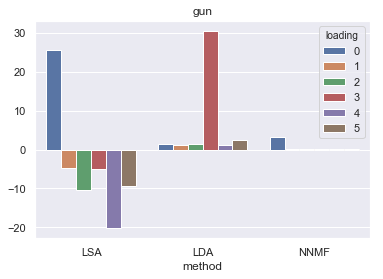

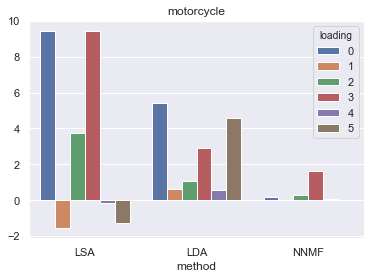

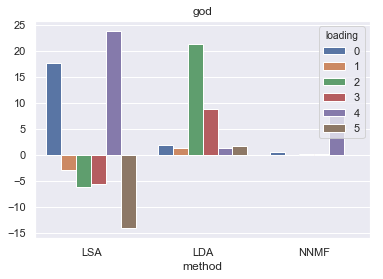

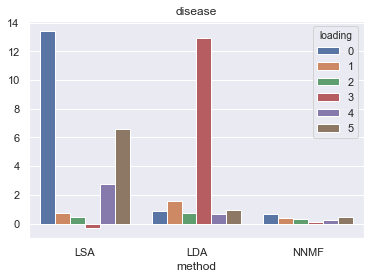

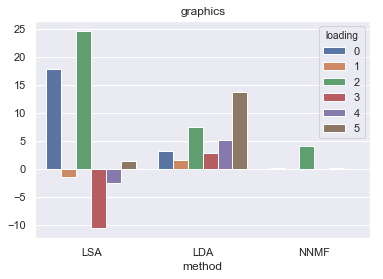

In [23]:
# The words to look at.
targetwords=['gun','motorcycle','god','disease','graphics']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 6, axis=0)
wordloadings['loading']=[0,1,2,3,4,5]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()


I chose six topics from the 20 newsgroups dataset that seeming the most interesting to me. I cleaned the text using rgex expressions that any characters and punctuation that wasn't a letter. This left a few stray single letter words that I further removed. I then wrote a function to impliment Spacy into Tfidfvectorizer to lemmatize the words. I also add some stop words to the stop word list. After that I implimented each algoritim in the same fashion that the guided example did. After all was said and done it looks like NNMF produced topics that best matched the articles from 20 newsgroup that were processed. As in the guided example I also put in some words to examine sparsity that seem to match the topics of the original articles. I think that NNMF works the best because of how sparce the data is. Even though the word loadings are lower that the other models overall the words that are important tend to stand alone within the topic. 